# Doing simple sentiment analyses on a Twitter archive
Here we explore how the Personal Data Notebooks can be used to get additional information out of a full Twitter archive. To use this notebook you need to have uploaded a Twitter archive into your *Open Humans* account through http://twarxiv.org. 

In a first step we again start by loading all the needed modules. As our sentiment analysis will use `textblob` we need to install this module first, as it's not available by default. We can do so with

```
import sys
!conda install --yes --prefix {sys.prefix} textblob
```

After this follows a huge list of function declarations with `def function():`. Let's take these for granted for now. I've basically [copy & pasted these from the code of the Twitter Archive Analyser](https://github.com/gedankenstuecke/twitter-analyser/blob/master/tweet_display/read_data.py). I only removed the local time zone calculations as we won't need these for a start and installing them would take rather long.

In [1]:
# LOAD OUR MODULES 
%matplotlib inline

import os, requests, json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import zipfile
import pytz
import io

# install textblob package, might take a while
import sys
!conda install --yes --prefix {sys.prefix} textblob
from textblob import TextBlob

!{sys.executable} -m pip install emoji
import emoji

# THIS CODE BELOW IS COPIED FROM TWARXIV.ORG AS IT ALREADY DOES EXACTLY WHAT WE WANT FOR READING IN THE DATA

# READ JSON FILES FROM TWITTER ARCHIVE!

def check_hashtag(single_tweet):
    '''check whether tweet has any hashtags'''
    return len(single_tweet['entities']['hashtags']) > 0


def check_media(single_tweet):
    '''check whether tweet has any media attached'''
    return len(single_tweet['entities']['media']) > 0


def check_url(single_tweet):
    '''check whether tweet has any urls attached'''
    return len(single_tweet['entities']['urls']) > 0


def check_retweet(single_tweet):
    '''
    check whether tweet is a RT. If yes:
    return name & user name of the RT'd user.
    otherwise just return nones
    '''
    if 'retweeted_status' in single_tweet.keys():
        return (single_tweet['retweeted_status']['user']['screen_name'],
                single_tweet['retweeted_status']['user']['name'])
    else:
        return (None, None)


def check_coordinates(single_tweet):
    '''
    check whether tweet has coordinates attached.
    if yes return the coordinates
    otherwise just return nones
    '''
    if 'coordinates' in single_tweet['geo'].keys():
        return (single_tweet['geo']['coordinates'][0],
                single_tweet['geo']['coordinates'][1])
    else:
        return (None, None)


def check_reply_to(single_tweet):
    '''
    check whether tweet is a reply. If yes:
    return name & user name of the user that's replied to.
    otherwise just return nones
    '''
    if 'in_reply_to_screen_name' in single_tweet.keys():
        name = None
        for user in single_tweet['entities']['user_mentions']:
            if user['screen_name'] == single_tweet['in_reply_to_screen_name']:
                name = user['name']
                break
        return (single_tweet['in_reply_to_screen_name'], name)
    else:
        return (None, None)


def create_dataframe(tweets):
    '''
    create a pandas dataframe from our tweet jsons
    '''

    # initalize empty lists
    utc_time = []
    longitude = []
    latitude = []
    hashtag = []
    media = []
    url = []
    retweet_user_name = []
    retweet_name = []
    reply_user_name = []
    reply_name = []
    text = []
    # iterate over all tweets and extract data
    for single_tweet in tweets:
        utc_time.append(datetime.datetime.strptime(single_tweet['created_at'],
                                                   '%Y-%m-%d %H:%M:%S %z'))
        coordinates = check_coordinates(single_tweet)
        latitude.append(coordinates[0])
        longitude.append(coordinates[1])
        hashtag.append(check_hashtag(single_tweet))
        media.append(check_media(single_tweet))
        url.append(check_url(single_tweet))
        retweet = check_retweet(single_tweet)
        retweet_user_name.append(retweet[0])
        retweet_name.append(retweet[1])
        reply = check_reply_to(single_tweet)
        reply_user_name.append(reply[0])
        reply_name.append(reply[1])
        text.append(single_tweet['text'])
    # convert the whole shebang into a pandas dataframe
    dataframe = pd.DataFrame(data={
                            'utc_time': utc_time,
                            'latitude': latitude,
                            'longitude': longitude,
                            'hashtag': hashtag,
                            'media': media,
                            'url': url,
                            'retweet_user_name': retweet_user_name,
                            'retweet_name': retweet_name,
                            'reply_user_name': reply_user_name,
                            'reply_name': reply_name,
                            'text': text
    })
    return dataframe


def read_files(zip_url):
    tf = tempfile.NamedTemporaryFile()
    print('downloading files')
    tf.write(requests.get(zip_url).content)
    tf.flush()
    zf = zipfile.ZipFile(tf.name)
    print('reading index')
    with zf.open('data/js/tweet_index.js', 'r') as f:
        f = io.TextIOWrapper(f)
        d = f.readlines()[1:]
        d = "[{" + "".join(d)
        json_files = json.loads(d)
    data_frames = []
    print('iterate over individual files')
    for single_file in json_files:
        print('read ' + single_file['file_name'])
        with zf.open(single_file['file_name']) as f:
            f = io.TextIOWrapper(f)
            d = f.readlines()[1:]
            d = "".join(d)
            tweets = json.loads(d)
            df_tweets = create_dataframe(tweets)
            data_frames.append(df_tweets)
    return data_frames


def create_main_dataframe(zip_url='http://ruleofthirds.de/test_archive.zip'):
    print('reading files')
    dataframes = read_files(zip_url)
    print('concatenating...')
    dataframe = pd.concat(dataframes)
    dataframe = dataframe.sort_values('utc_time', ascending=False)
    dataframe = dataframe.set_index('utc_time')
    dataframe = dataframe.replace(to_replace={
                                    'url': {False: None},
                                    'hashtag': {False: None},
                                    'media': {False: None}
                                    })
    return dataframe


Fetching package metadata ...............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda:
#
textblob                  0.15.0                     py_0    conda-forge


Once our packages are installed and we declared all of our functions we can get started with requesting the data from *Open Humans*. Using our `access_token` which we get from `os.environ.get('OH_ACCESS_TOKEN')` we get a `json` object that contains all of our data sources. 

We then loop over all of them to identify which is the zipped twitter archive and save the URL. Once that's done we can just call the master function `create_main_dataframe` that was declared above to create a `pandas` dataframe out of this.

In [2]:
response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
user = json.loads(response.content)
for entry in user['data']:
    if entry['source'] == "direct-sharing-70":
        twitter_data_url = entry['download_url']
        break
twitter_data_url

twitter_data = create_main_dataframe(zip_url=twitter_data_url)

reading files
downloading files
reading index
iterate over individual files
read data/js/tweets/2017_12.js
read data/js/tweets/2017_11.js
read data/js/tweets/2017_10.js
read data/js/tweets/2017_09.js
read data/js/tweets/2017_08.js
read data/js/tweets/2017_07.js
read data/js/tweets/2017_06.js
read data/js/tweets/2017_05.js
read data/js/tweets/2017_04.js
read data/js/tweets/2017_03.js
read data/js/tweets/2017_02.js
read data/js/tweets/2017_01.js
read data/js/tweets/2016_12.js
read data/js/tweets/2016_11.js
read data/js/tweets/2016_10.js
read data/js/tweets/2016_09.js
read data/js/tweets/2016_08.js
read data/js/tweets/2016_07.js
read data/js/tweets/2016_06.js
read data/js/tweets/2016_05.js
read data/js/tweets/2016_04.js
read data/js/tweets/2016_03.js
read data/js/tweets/2016_02.js
read data/js/tweets/2016_01.js
read data/js/tweets/2015_12.js
read data/js/tweets/2015_11.js
read data/js/tweets/2015_10.js
read data/js/tweets/2015_09.js
read data/js/tweets/2015_08.js
read data/js/tweets/2015_

Now we have a dataframe called `twitter_data` which contains a lot of metadata, along with all the tweets in the column `twitter_data['text']`.

In [3]:
twitter_data.head()

,hashtag,latitude,longitude,media,reply_name,reply_user_name,retweet_name,retweet_user_name,text,url
utc_time,,,,,,,,,,
2017-12-14 08:22:12+00:00,NaN,NaN,NaN,1.0,None,None,None,None,Laser show https://t.co/wpgZe51co5,NaN
2017-12-14 03:36:15+00:00,NaN,NaN,NaN,NaN,None,None,None,None,death by a thousand staples https://t.co/K4WVe...,1.0
2017-12-14 00:11:37+00:00,NaN,37.8515,-122.295,NaN,Philipp Bayer,PhilippBayer,None,None,@PhilippBayer for the old blastall as well as ...,NaN
2017-12-13 18:34:50+00:00,NaN,37.8632,-122.273,1.0,None,None,None,None,Sending this to people who graduated in bioinf...,NaN
2017-12-13 16:52:32+00:00,NaN,NaN,NaN,NaN,None,None,Philipp Bayer,PhilippBayer,RT @PhilippBayer: Since Norman Borlaug's Nobel...,NaN


Let's now add the `polarity` and `subjectivity` to the tweets with `textblob`. `polarity` values range between `+1` and `-1`, with `+1` being extremely positive, `-1` extremely negative and `0` being neutral. `subjectivity` values range between `0` and `1`, with larger numbers meaning the text is more subjective. 

We add these numbers to our dataframe and for a start just remove all the `0` values, as these can also indicate a lack of data/classifications.

In [4]:
polarity = []
subjectivity = []
twitter_data['blob'] = twitter_data['text'].apply(TextBlob)
for entry in twitter_data['blob']:
    polarity.append(entry.sentiment.polarity)
    subjectivity.append(entry.sentiment.subjectivity)
twitter_data['polarity'] = polarity
twitter_data['subjectivity'] = subjectivity
twitter_data = twitter_data.replace(0, np.nan)

Let's now normalize these values for each day instead of looking at individual tweets. For both `polarity` and `subjectivity` we calculate the daily maximum, minimum and mean values along with the standard deviation. 

In a next step we further smoothen out these values by applying a 30-day rolling average to remove the impact daily fluctuations. 

In [5]:
# get 30-day averaged standard deviations for polarity & subjectivity
twitter_std = twitter_data.groupby(twitter_data.index.date).std()
twitter_std.index = pd.to_datetime(twitter_std.index)
twitter_std_rolling = twitter_std.rolling('30d').mean()

# get 30-day mean averaged daily means for polarity & subjectivity
twitter_mean = twitter_data.groupby(twitter_data.index.date).mean()
twitter_mean.index = pd.to_datetime(twitter_mean.index)
twitter_mean_rolling = twitter_mean.rolling('30d').mean()

# get 30-day averaged maximum values for polarity & subjectivity
twitter_max = twitter_data.groupby(twitter_data.index.date).max()
twitter_max.index = pd.to_datetime(twitter_max.index)
twitter_max_rolling = twitter_max.rolling('30d').mean()

# get 30-day averaged minimum for polarity & subjectivity
twitter_min = twitter_data.groupby(twitter_data.index.date).min()
twitter_min.index = pd.to_datetime(twitter_min.index)
twitter_min_rolling = twitter_min.rolling('30d').mean()

We can now pack all of this in two new data frames for the subsequent plotting.

In [6]:
polarity = pd.DataFrame(data={
    "max_polarity": twitter_max_rolling["polarity"],
    "mean_polarity": twitter_mean_rolling["polarity"],
    "min_polarity": twitter_min_rolling["polarity"],    
    "std_polarity": twitter_std_rolling["polarity"]    
})

subjectivity = pd.DataFrame(data={
    "max_subjectivity": twitter_max_rolling["subjectivity"],
    "mean_subjectivity": twitter_mean_rolling["subjectivity"],
    "min_subjectivity": twitter_min_rolling["subjectivity"],    
    "std_subjectivity": twitter_std_rolling["subjectivity"]    
})

## Visualization
Let's start with the polarity. Looking at the mean it seems that my tweets overall seem to be pretty neutral. Looking at the maximum/minimum polarity we see that positive & negative polarity are more or less balanced. Put in other words: For each mean-spirited tweet there's one full of praise ;-)

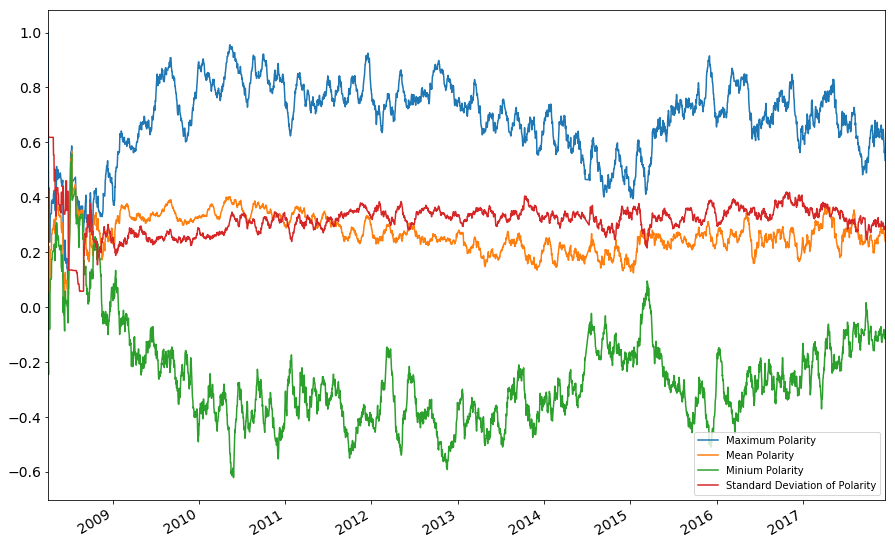

In [7]:
pt = polarity.plot(y=['max_polarity','mean_polarity','min_polarity','std_polarity'],figsize=(15,10),fontsize=14)
pt.legend(['Maximum Polarity','Mean Polarity','Minium Polarity','Standard Deviation of Polarity'])

Looking at the `subjectivity` is a bit more interesting: It seems my tweets have grown less subjective over time. Which might have plenty of reasons: My active political career coming to a finish, growing a larger audience and thus tweeting more responsibly, or just plain growing old. 

I guess we'll never know. Unless one of you has a good idea of how to use the Twitter archives to investigate this further. If you do: Hit me up on twitter @gedankenstuecke.

## Emoji usage
Let's have a look into the emoji usage next. To do this we loaded the `emoji` package on top. This has a dictionary of (many) emoji, but not of all of them. Especially never ones are bound to be absent, as are the multi-character flag emojis like 🇮🇱 🇭🇰 🇬🇷. But for a first look this list should be good enough. We write a small `number_of_emoji` function that as expected returns the number of emoji found for a single tweet. We can then apply this function to our `twitter_data` dataframe.

In [8]:
def number_emoji(row):
    n_emoji = 0
    for character in row['text']:
        if character in emoji.UNICODE_EMOJI:
            n_emoji += 1
    return n_emoji

twitter_data['emoji_count'] = twitter_data.apply(number_emoji, axis=1)

We can now sum up over the number of emoji per day and then again apply a rolling average to minimize the influence of daily fluctuations. Once that's done we can make our plots 🎉

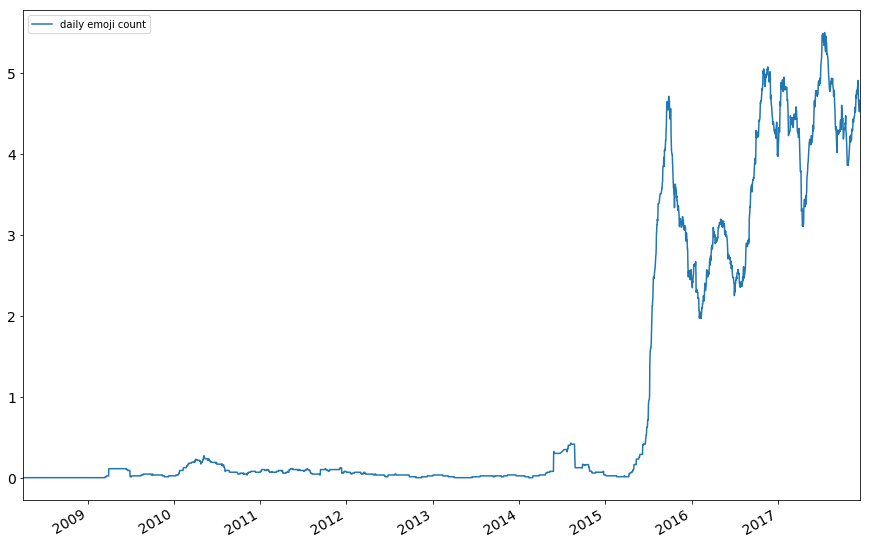

In [9]:
twitter_emoji = twitter_data.groupby(twitter_data.index.date).sum()
twitter_emoji.index = pd.to_datetime(twitter_emoji.index)
twitter_emoji_rolling = twitter_emoji.rolling('90d').mean()

pt = twitter_emoji_rolling.plot(y=['emoji_count'],figsize=(15,10),fontsize=14)
pt.legend(['daily emoji count'])

Let's also have a look what the most common emoji are. We iterate over all the tweets, and count the occurrences of each emoji. Ultimately we only look at those that appear at least 5 times. 

In [10]:
from collections import defaultdict

emojis = defaultdict(int)
for tweet in twitter_data['text']:
    for character in tweet:
        if character in emoji.UNICODE_EMOJI:
            emojis[character] += 1

s = [(k, emojis[k]) for k in sorted(emojis, key=emojis.get, reverse=True)]
for k,v in s:
    print(k,v)
    if v < 5:
        break

😂 485
😍 219
💖 205
🎉 181
✈ 140
👍 128
😉 100
😊 79
🐶 71
😱 69
™ 69
😢 37
♀ 36
☺ 35
🙏 33
✔ 33
😭 30
👋 27
🤷 26
🤔 26
❤ 26
🔥 23
🚗 22
😘 21
🍄 21
💩 19
🍆 19
💃 16
☕ 16
🍻 15
😇 15
📊 15
😴 15
😎 15
🌈 15
⭐ 15
🍩 15
📚 14
🐼 14
✅ 14
🔬 14
🏽 14
😔 14
🐦 14
© 13
👏 11
🍦 11
😀 11
💘 11
💓 11
🎄 10
🎊 10
🎈 10
🏼 10
🐧 10
🐢 10
💕 10
♥ 10
💜 9
🤓 9
🏃 9
🍾 9
🍨 9
🐳 9
🎸 9
💉 9
🍰 9
🍌 9
👀 9
😞 8
🏳 8
☀ 8
🍜 8
😜 8
👌 8
💤 8
✊ 8
🔮 8
✨ 7
🍪 7
🐿 7
🌊 7
😒 7
🚂 7
🐌 7
🍺 7
😛 7
😳 7
🍧 7
🐍 6
😥 6
👨 6
🌟 6
👓 6
🐛 6
🚙 6
🌋 6
🐴 6
📉 6
☑ 6
💸 5
🚨 5
🙄 5
🔨 5
🐰 5
🦄 5
🐻 5
🌱 5
👇 5
💰 5
🤦 5
☔ 5
💍 5
😋 5
🌲 5
🌍 5
👉 5
😕 5
💨 5
⚡ 5
💾 4


Using this list of most common emoji I manually categorized some of them into sub-categories to see how these categories vary over time:

In [11]:
emoji_love = ["💖","😍","😘","🍆","🌈","💘","💓","💕","♥","💜"]
emoji_science = ['📉','🌱','🐌','🤓','🔬','📚','📊','🍄']
emoji_joy = ['😋','😛','😜','😀','😎','☺','😊','😉','👍','😂']
emoji_celebrate = ['☑','🍺','✨','🍾','🎈','🎊','✅','🍻','✔','🎉']
emoji_sad = ['😕','🤦','😥','😳','😒','😞','😔','💩','🔥','🤷','😭','😢','😱']
emoji_travel = ['🌍','🚙','🚂','🚗','✈']

We can now apply a small function with these sub-categories to get the number of emoji for each tweet/category combination:

In [12]:
def classify_number_emoji(row, classifier):
    n_emoji = 0
    for character in row:
        if character in classifier:
            n_emoji += 1
    return n_emoji

twitter_data['emoji_count_love'] = twitter_data['text'].apply(classify_number_emoji,args=(emoji_love,))
twitter_data['emoji_count_science'] = twitter_data['text'].apply(classify_number_emoji,args=(emoji_science,))
twitter_data['emoji_count_joy'] = twitter_data['text'].apply(classify_number_emoji,args=(emoji_joy,))
twitter_data['emoji_count_celebrate'] = twitter_data['text'].apply(classify_number_emoji,args=(emoji_celebrate,))
twitter_data['emoji_count_sad'] = twitter_data['text'].apply(classify_number_emoji,args=(emoji_sad,))
twitter_data['emoji_count_travel'] = twitter_data['text'].apply(classify_number_emoji,args=(emoji_travel,))

Let's get the daily sum of emoji for each of the categories and minimize fluctuations with a 90-day rolling average:

In [13]:
twitter_emoji = twitter_data.groupby(twitter_data.index.date).sum()
twitter_emoji.index = pd.to_datetime(twitter_emoji.index)
twitter_emoji_rolling = twitter_emoji.rolling('90d').mean()

Plotting the emoji usage we can see that I'm becoming a much more joyful person over time 😂 Though I should probably check on my loving tweets. 😉

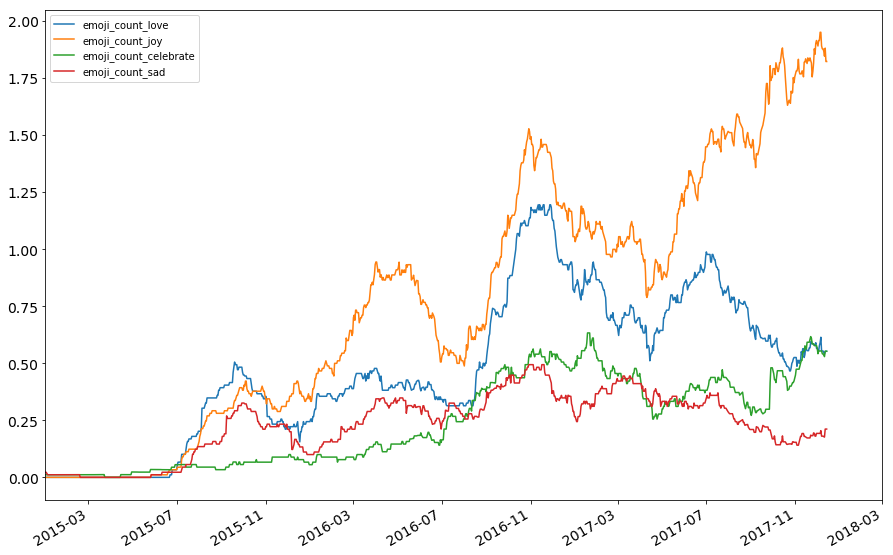

In [14]:
pt = twitter_emoji_rolling.plot(y=['emoji_count_love',
                                   #'emoji_count_science',
                                   'emoji_count_joy',
                                   'emoji_count_celebrate',
                                   'emoji_count_sad'],
                                   #'emoji_count_travel'],
                                figsize=(15,10),
                                fontsize=14,
                                xlim=["2015-01-01","2018-03-01"])
pt.legend(['emoji_count_love',
        #'emoji_count_science',
        'emoji_count_joy',
        'emoji_count_celebrate',
        'emoji_count_sad',])
        #'emoji_count_travel'])